In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
from rootpy.tree import Tree, TreeChain
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.12/07


In [3]:
infile_r = None  # input file handle

def load_zmm_all():
  global infile_r
  pufiles = []
  #pufiles += ['root://cmsxrootd-site.fnal.gov//store/group/l1upgrades/L1MuonTrigger/P2_10_4_0/ntuple_ZMM_PU140/ZMM_14TeV_TuneCUETP8M1_Pythia8/CRAB3/190324_214931/0000/ntuple_ZMM_PU140_%i.root' % (i+1) for i in xrange(5)]
  #pufiles += ['root://cmsxrootd-site.fnal.gov//store/group/l1upgrades/L1MuonTrigger/P2_10_4_0/ntuple_ZMM_PU200/ZMM_14TeV_TuneCUETP8M1_Pythia8/CRAB3/190324_215105/0000/ntuple_ZMM_PU200_%i.root' % (i+1) for i in xrange(27)]
  #pufiles += ['root://cmsxrootd-site.fnal.gov//store/group/l1upgrades/L1MuonTrigger/P2_10_4_0/ntuple_SingleMuon_PU140/SingleMu_FlatPt-2to100/CRAB3/190308_003235/0000/ntuple_SingleMuon_PU140_%i.root' % (i+1) for i in xrange(25)]
  pufiles += ['root://cmsxrootd-site.fnal.gov//store/group/l1upgrades/L1MuonTrigger/P2_10_4_0/ntuple_SingleMuon_PU200/SingleMu_FlatPt-2to100/CRAB3/190308_003350/0000/ntuple_SingleMuon_PU200_%i.root' % (i+1) for i in xrange(26)]
  
  tree = TreeChain('ntupler/tree', pufiles)
  
  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return tree

In [4]:
maxEvents = -1
#maxEvents = 500000
#maxEvents = 10000

In [5]:
# Main analysis

def analysis(verbose=1):
  tree = load_zmm_all()
  
  out_part = []
  
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    ievt_part = []
    ievt_sim_tp = []
    
    # Select genParticles
    select_part = lambda part: (part.status == 1)
    
    for ipart, part in enumerate(evt.particles):
      if select_part(part):
        parameters = (np.true_divide(part.q, part.pt), part.phi, part.eta, part.vx, part.vy, part.vz)
        ievt_part.append(parameters)
        ievt_sim_tp.append(ipart)
    
    # Didn't keep muon |eta| > 2.5 
    if len(ievt_part) == 0:
      continue
    
    # Sanity check
    assert(len(ievt_part) == 2)
    
    found_muon_1 = False
    found_muon_2 = False
    
    for ihit, hit in enumerate(evt.hits):
      if (hit.bx == 0) and (1 <= hit.type <= 4) and (hit.station == 1):
        if (hit.sim_tp1 == ievt_sim_tp[0]):
          found_muon_1 = True
        elif (hit.sim_tp1 == ievt_sim_tp[1]):
          found_muon_2 = True
    
    if ievt < 10:
      for ipart, part in enumerate(evt.particles):
        if select_part(part):
          print ipart, part.pt, part.eta, part.phi, part.genp, part.status
      print "Found muons:", found_muon_1, found_muon_2
    
    # Output
    if found_muon_1 and found_muon_2:
      out_part += ievt_part
    continue  # end loop over events

  if verbose: print "DONE"
  return np.asarray(out_part, dtype=np.float32)

In [6]:
loaded = np.load('drellyan_out.0.npz')
out_part = loaded['out_part']

print out_part.shape

(354936, 6)


In [7]:
# Styling
plt.style.use('tdrstyle.mplstyle')

In [8]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

1.0 1.0
[0. 0.]


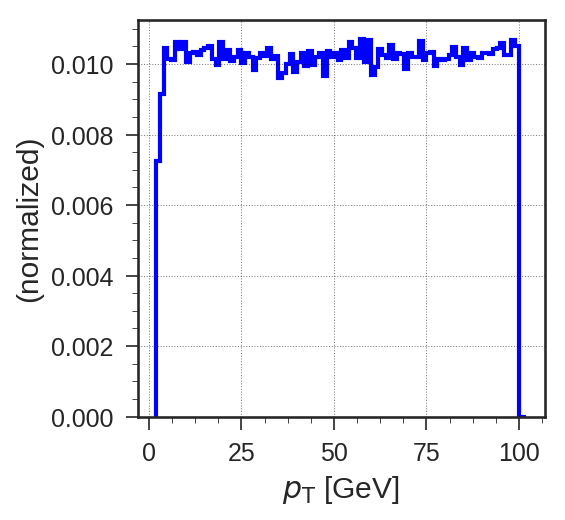

In [9]:
# Find PDF for pT

from scipy.optimize import curve_fit

def mb(x, a0, a1, a2):
  #return (a0 + a1*x + a2/x)
  return (a0 + a1*x + a2*np.log(x))

def fit_mb(hist, edges, p0=None):
  hist = hist.astype('float64')
  edges = edges.astype('float64')
  xdata = (edges[1:] + edges[:-1])/2
  ydata = hist
  popt, pcov = curve_fit(mb, xdata, ydata, p0=p0)
  if not np.isfinite(pcov).all():
    raise Exception('Fit has failed to converge.')
  return popt

part_pt = np.abs(1.0/out_part[:,0])

fig, ax = plt.subplots(figsize=(3.5,3.5))
hist, edges, _ = ax.hist(np.clip(part_pt, 1., 101.), bins=100, range=(2.,102.), density=True, histtype='step', color='b', linewidth=2)
ax.set_xlabel(r'$p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'(normalized)')
#ax.set_yscale('log')

# bin width
binw = (102.-2.)/100
print hist.sum() * binw, binw

# pad zero bins
print hist[hist < 1e-5]
hist[hist < 1e-5] = 1e-5

# Fit
#hist1 = np.log(hist * binw)  # logy, include bin width
#popt = fit_mb(hist1[:-4], edges[:-4], p0=None)
##popt = fit_mb(hist1, edges, p0=None)
#print('a0, a1, a2 = ({0}, {1}, {2})'.format(*popt))
#xdata = (edges[1:] + edges[:-1])/2
#ax.plot(xdata, np.exp(mb(xdata, popt[0], popt[1], popt[2]))/binw, color='c')

plt.show()